In [1]:
import networkx as nx
from neo4j import GraphDatabase
import pandas as pd
from pyvis.network import Network
import matplotlib.pyplot as plt
from netgraph import Graph
from IPython.display import HTML, display
driver = GraphDatabase.driver('bolt://neo4j:7687', auth=("neo4j", "BDII2023"))
session = driver.session()
def run_query(query, return_data=True, **kwargs):
        results = session.run(query, kwargs)
        if return_data:
            return results.data()
        return results

### 1. **Mapamundi**: El mapamundi debe mostrar las distintas áreas del juego y como se interconectan unas con otras.


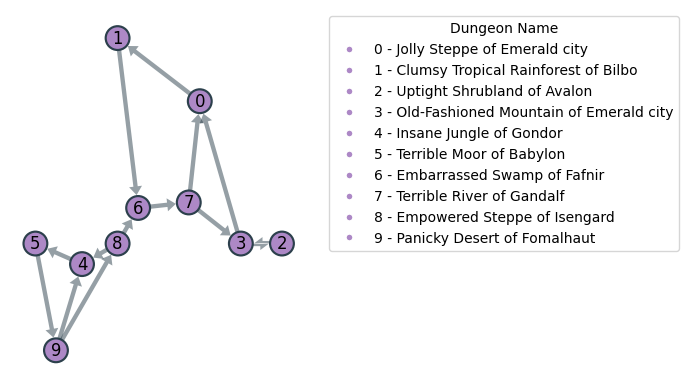

In [2]:
data = run_query("""
MATCH (a1:Area)-[r:SHORTEST_PATH]->(a2:Area)
RETURN a1.name as source, a2.name as target, r.length as length
""")

G = nx.DiGraph()

# Node mapping to integers and reverse mapping for legend
node_to_int = {}
int_to_node = {}
node_counter = 0

for row in data:
    if row['source'] not in node_to_int:
        node_to_int[row['source']] = node_counter
        int_to_node[node_counter] = row['source']
        node_counter += 1
    if row['target'] not in node_to_int:
        node_to_int[row['target']] = node_counter
        int_to_node[node_counter] = row['target']
        node_counter += 1
    G.add_edge(node_to_int[row['source']], node_to_int[row['target']])

# Visualization
fig, ax = plt.subplots()
node_color = "#AD88C6"
g = Graph(
    G,
    node_layout="radial",
    arrows=True,
    node_labels=True,
    # edge_layout="curved",
    node_size=3,
    node_color=node_color,
    ax=ax,
)

# Create a legend mapping integers back to node names
legend_handles = [plt.Line2D([], [], marker="o", color="w", label=f"{i} - {int_to_node[i]}",
                             markerfacecolor=node_color, markersize=5) for i in int_to_node]
ax.legend(handles=legend_handles, title="Dungeon Name", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('mapamundi.png', bbox_inches='tight')
plt.show()

### 2. **Listado mazmorras**: El listado de mazmorras debe mostrar todas las mazmorras del juego y las áreas con las que están conectadas. Debería ser capaz de ver a simple vista que mazmorras están en cada área y mazmorras hacen de puente entre dos áreas.


In [3]:
import matplotlib.pyplot as plt
query = """
MATCH (a: Area),
      (b: Area),
      (a)-[ca:IS_CONNECTED]->(),
      ()-[cb:IS_CONNECTED]->(b),
       p = shortestPath((a)-[:IS_CONNECTED*]->(b))
WHERE a <> b AND ca.dungeon_name = cb.dungeon_name
RETURN a.name as source, b.name as target, ca.dungeon_name as dungeon_name
"""
data = pd.DataFrame(run_query(query))
G = nx.DiGraph()
# Tripartite graph area -> dungeon -> area
for i, row in enumerate(data.itertuples()):
    source_node = {'name': row.source, 'type': 'area1'}
    target_node = {'name': row.target, 'type': 'area2'}
    dungeon_node = {'name': row.dungeon_name, 'type': 'dungeon'}
    G.add_node(row.source, **source_node)
    G.add_node(row.target, **target_node)
    G.add_node(row.dungeon_name, **dungeon_node)
    G.add_edge(row.source, row.dungeon_name)
    G.add_edge(row.dungeon_name, row.target)

# Set the position of each node 
# color = ['blue' if node[1]['type'] in ['area1', 'area2'] else 'green' for node in G.nodes(data=True)]
color = {node[0]: 'skyblue' if node[1]['type'] in ['area1', 'area2'] else 'salmon' for node in G.nodes(data=True)}

pos = nx.planar_layout(G)

# plt.figure(figsize=(20, 20))
# nx.draw(G, with_labels=False, node_color=color.values(), pos=pos, font_size=10)

In [4]:
for node in G.nodes:
    G.nodes[node]['x'] = pos[node][0]
    G.nodes[node]['y'] = pos[node][1]
    G.nodes[node]['color'] = color[node]
    G.nodes[node]['shape'] = 'box'

net = Network(notebook=True, directed=True, height='950px')
net.from_nx(G)
# net.show_buttons(filter_=['physics'])  # Permite ajustar la física interactivamente si es necesario
net.set_options("""const options = {
  "physics": {
    "barnesHut": {
      "avoidOverlap": 0.4
    },
    "minVelocity": 0.75
  }
}""")


net.show("listado_mazmorras.html", notebook=True)
# Manually add legend to HTML file
legend_html = """
<div style="position: absolute; top: 20px; right: 20px; background-color: white; padding: 10px; border-radius: 5px; box-shadow: 0 0 10px rgba(0, 0, 0, 0.2);">
    <div style="background-color: skyblue; width: 20px; height: 20px; display: inline-block; margin-right: 5px;"></div>
    <span style="color:black;">Area</span><br>
    <div style="background-color: salmon; width: 20px; height: 20px; display: inline-block; margin-right: 5px;"></div>
    <span style="color:black;">Dungeon</span>
</div>
"""

with open("listado_mazmorras.html", "r") as file:
    html_content = file.read()

# Insert legend HTML content before the end of the <body> tag
html_content = html_content.replace("</body>", legend_html + "</body>")

# Write the modified content back to the HTML file
with open("listado_mazmorras.html", "w") as file:
    file.write(html_content)

listado_mazmorras.html


### 3. **Mini-mapa mazmorra**: Dada una mazmorra el mini mapa debe mostrar información que ayude a los aventureros a explorar la mazmorra. En el mini mapa debe ser fácil reconocer las entradas y las salidas de una mazmorra. Los pasillos que llevan a salas interesantes. Las zonas donde hay monstruos o tesoros y el nivel/precio de estos

In [5]:
import matplotlib.pyplot as plt
mazmorra = "Bentclock, Laboratory of the Sexy Thieves"

query_dungeon_map = """
MATCH (r1: Room{dungeon_name: $mazmorra})-[:IS_CONNECTED]->(r2: Room{dungeon_name: $mazmorra})
RETURN r1.room_name as source, r2.room_name as target
"""
dungeon_map = pd.DataFrame(run_query(query_dungeon_map, mazmorra=mazmorra))

query_entry_exit = """
MATCH (a: Area)-[:IS_CONNECTED]->(r_entry: Room{dungeon_name: $mazmorra}),
        (r_exit: Room{dungeon_name: $mazmorra})-[:IS_CONNECTED]->(b: Area)
RETURN r_entry.room_name as entry, r_exit.room_name as exit
"""
entry_exit = run_query(query_entry_exit, mazmorra=mazmorra)[0]

query_monsters = """
MATCH (r: Room{dungeon_name: $mazmorra})-[c_m:CONTAINS]->(m: Monster)
RETURN r.room_name as room, m.name as monster, c_m.amount as amount_monsters
"""
monsters = pd.DataFrame(run_query(query_monsters, mazmorra=mazmorra))

query_total_level = """
MATCH (r: Room{dungeon_name: $mazmorra})-[c:CONTAINS]->(m: Monster)
RETURN r.room_name as room, SUM(m.level * c.amount) as total_level
"""
total_level = pd.DataFrame(run_query(query_total_level, mazmorra=mazmorra))

query_total_gold = """
MATCH (r: Room{dungeon_name: $mazmorra})-[c:CONTAINS]->(l: Loot)
RETURN r.room_name as room, SUM(c.amount * l.gold) as total_gold
"""
total_gold = pd.DataFrame(run_query(query_total_gold, mazmorra=mazmorra))

G = nx.Graph()
for i, row in enumerate(dungeon_map.itertuples()):
    G.add_edge(row.source, row.target)

for node in G.nodes:
    G.nodes[node]['entry'] = False
    G.nodes[node]['exit'] = False
    if node == entry_exit['entry']:
        G.nodes[node]['entry'] = True
    if node == entry_exit['exit']:
        G.nodes[node]['exit'] = True
    total_level_row = total_level[total_level['room'] == node]
    if not total_level_row.empty:
        G.nodes[node]['total_level'] = int(total_level_row['total_level'].values[0])
    else:
        G.nodes[node]['total_level'] = 0
    total_gold_row = total_gold[total_gold['room'] == node]
    if not total_gold_row.empty:
        G.nodes[node]['total_gold'] = int(total_gold_row['total_gold'].values[0])
    else:
        G.nodes[node]['total_gold'] = 0

pos = nx.kamada_kawai_layout(G)

In [6]:
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LinearSegmentedColormap

# Suponemos que G es tu grafo y ya tiene nodos y aristas definidos
# Crear un mapa de colores personalizado de gris claro a amarillo
colors = ["#999999", "#ffff33"]
cmap = LinearSegmentedColormap.from_list("custom_yellow", colors, N=256)

# Crear la instancia de Network
net = Network(notebook=True, height='950px')

# Obtener los valores de 'max_level' y 'max_gold'
max_level = max(nx.get_node_attributes(G, 'total_level').values())
min_gold = min(nx.get_node_attributes(G, 'total_gold').values())
max_gold = max(nx.get_node_attributes(G, 'total_gold').values())

# Tamaño estándar para nodos de entrada y salida
standard_size = 50

# Encuentra el nodo con el máximo oro
max_gold_node = max(G.nodes, key=lambda x: G.nodes[x]['total_gold'])

# Encuentra el nodo de entrada (suponiendo que es el nodo con 'entry' = True)
entry_node = next((node for node, data in G.nodes(data=True) if data.get('entry', False)), None)

# Calcular el camino más corto desde el nodo de entrada al nodo con máximo oro
if entry_node is not None and nx.has_path(G, entry_node, max_gold_node):
    path = nx.shortest_path(G, source=entry_node, target=max_gold_node)
    path_edges = list(zip(path, path[1:]))
else:
    path, path_edges = [], []

# Añadir los nodos al objeto Network
for node, attr in G.nodes(data=True):
    title = f"{node}\nTotal gold: {attr['total_gold']}\nTotal level: {attr['total_level']}"
    if attr['entry']:
        # Nodo de entrada: forma cuadrada y color rojo
        net.add_node(node, size=standard_size, color="red", shape="square", title="Entrance\n"+title)
    elif attr['exit']:
        # Nodo de salida: forma cuadrada y color verde
        net.add_node(node, size=standard_size, color="green", shape="square", title="Exit\n"+title)
    else:
        size = 10 + (attr['total_level'] / max_level) * 100  # Calcular tamaño del nodo
        color_value = (attr['total_gold'] - min_gold) / (max_gold - min_gold)
        color = cmap(color_value)  # Usar el mapa de colores personalizado para obtener el color
        hex_color = matplotlib.colors.rgb2hex(color)  # Convertir RGB a HEX
        net.add_node(node, size=size, color=hex_color, title=title)

# Añadir las aristas al objeto Network
for edge in G.edges():
    width = 5 if edge in path_edges or (edge[1], edge[0]) in path_edges else 1
    color = "red" if edge in path_edges or (edge[1], edge[0]) in path_edges else "black"
    net.add_edge(*edge, width=width, color=color)

# Opciones para hacer los nodos más fáciles de manejar y mejorar la visualización
net.toggle_physics(True)  # Activa la física para una disposición más natural
# net.show_buttons(filter_=['physics'])  # Permite ajustar la física interactivamente si es necesario

# Guardar y mostrar el gráfico
net.show("minimapa_mazmorra.html", notebook=True)
# Generar la leyenda HTML
legend_html = """
<div style="position: absolute; top: 20px; right: 20px; background-color: white; padding: 10px; border-radius: 5px; box-shadow: 0 0 10px rgba(0, 0, 0, 0.2);">
    <div style="background-color: red; width: 20px; height: 20px; display: inline-block; margin-right: 5px;"></div>
    <span>Entrance</span><br>
    <div style="background-color: green; width: 20px; height: 20px; display: inline-block; margin-right: 5px;"></div>
    <span>Exit</span><br>
    <div style="display: inline-block; margin-top: 10px;">
        <div style="background: linear-gradient(to right, #999999 0%, #ffff33 100%); width: 100px; height: 20px; display: inline-block;"></div>
        <span style="margin-left: 5px;">Gold Quantity</span>
    </div><br>
    <span>Node radius: Monster Level </span>
</div>
"""

with open("minimapa_mazmorra.html", "r") as file:
    html_content = file.read()

# Insert legend HTML content before the end of the <body> tag
html_content = html_content.replace("</body>", legend_html + "</body>")

# Write the modified content back to the HTML file
with open("minimapa_mazmorra.html", "w") as file:
    file.write(html_content)

minimapa_mazmorra.html
